# Bước 0: Thiết lập Môi trường và Tải Dữ liệu

In [48]:
!pip install gensim

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
train_path = '/content/train.csv'
val_path = '/content/val.csv'
test_path = '/content/test.csv'

# Đọc dữ liệu
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

df_train.head()

Train shape: (8954, 2)
Validation shape: (1076, 2)
Test shape: (1076, 2)


,text,category
0,what alarms do i have set right now,alarm_query
1,checkout today alarm of meeting,alarm_query
2,report alarm settings,alarm_query
3,see see for me the alarms that you have set to...,alarm_query
4,is there an alarm for ten am,alarm_query


In [51]:
print("Columns:", df_train.columns.tolist())
print("\nSample data:")
print(df_train.head())

print("\nNumber of unique categories:", df_train['category'].nunique())
print("\nCategory distribution:")
print(df_train['category'].value_counts().head(10))

Columns: ['text', 'category']

Sample data:
                                                text     category
0                what alarms do i have set right now  alarm_query
1                    checkout today alarm of meeting  alarm_query
2                              report alarm settings  alarm_query
3  see see for me the alarms that you have set to...  alarm_query
4                       is there an alarm for ten am  alarm_query

Number of unique categories: 64

Category distribution:
category
alarm_set              159
social_post            159
qa_definition          159
alarm_query            158
general_quirky         158
iot_hue_lightchange    158
calendar_query         158
general_commandstop    158
lists_query            158
lists_createoradd      158
Name: count, dtype: int64


## Tiền xử lý các nhãn (intent) để chuyển chúng thành dạng số

In [52]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([df_train['category'], df_val['category'], df_test['category']]))

y_train = label_encoder.transform(df_train['category'])
y_val = label_encoder.transform(df_val['category'])
y_test = label_encoder.transform(df_test['category'])

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_[:10]}\n")

X_train_text = df_train['text'].values
X_val_text = df_val['text'].values
X_test_text = df_test['text'].values

print(f"Train samples: {len(X_train_text)}")
print(f"Validation samples: {len(X_val_text)}")
print(f"Test samples: {len(X_test_text)}")

Number of classes: 64
Classes: ['alarm_query' 'alarm_remove' 'alarm_set' 'audio_volume_down'
 'audio_volume_mute' 'audio_volume_up' 'calendar_query' 'calendar_remove'
 'calendar_set' 'cooking_recipe']

Train samples: 8954
Validation samples: 1076
Test samples: 1076


# Nhiệm vụ 1: (Warm-up Ôn bài cũ) Pipeline TF-IDF + Logistic Regression

In [53]:
tfidf_log_reg_pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(max_iter=1000, random_state=2, n_jobs=-1)
)

print("\nTraining TF-IDF + Logistic Regression...")
tfidf_log_reg_pipeline.fit(X_train_text, y_train)

y_pred_tfidf_log_reg = tfidf_log_reg_pipeline.predict(X_test_text)

accuracy_tfidf_log_reg = accuracy_score(y_test, y_pred_tfidf_log_reg)
f1_macro_tfidf_log_reg = f1_score(y_test, y_pred_tfidf_log_reg, average='macro')

print(f"\nAccuracy: {accuracy_tfidf_log_reg:.4f}")
print(f"F1-score (Macro): {f1_macro_tfidf_log_reg:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_log_reg,
                          target_names=label_encoder.classes_,
                          digits=4))


Training TF-IDF + Logistic Regression...

Accuracy: 0.8336
F1-score (Macro): 0.8300

Classification Report:
                          precision    recall  f1-score   support

             alarm_query     0.9474    0.9474    0.9474        19
            alarm_remove     1.0000    0.7273    0.8421        11
               alarm_set     0.8500    0.8947    0.8718        19
       audio_volume_down     1.0000    0.7500    0.8571         8
       audio_volume_mute     0.9231    0.8000    0.8571        15
         audio_volume_up     1.0000    1.0000    1.0000        13
          calendar_query     0.5789    0.5789    0.5789        19
         calendar_remove     0.7826    0.9474    0.8571        19
            calendar_set     0.8750    0.7368    0.8000        19
          cooking_recipe     0.9286    0.6842    0.7879        19
        datetime_convert     0.7778    0.8750    0.8235         8
          datetime_query     0.7083    0.8947    0.7907        19
        email_addcontact     0.8

# Nhiệm vụ 2: (Warm-up Ôn bài cũ) Pipeline Word2Vec (Trung bình) + Dense Layer

In [54]:
sentences_train = [text.lower().split() for text in X_train_text]
sentences_val = [text.lower().split() for text in X_val_text]
sentences_test = [text.lower().split() for text in X_test_text]

print("\nTraining Word2Vec model")
w2v_model = Word2Vec(
    sentences=sentences_train,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10,
    seed=42
)

print(f"Vocabulary size: {len(w2v_model.wv)}")
print(f"Vector size: {w2v_model.vector_size}")

def sentence_to_avg_vector(sentence, model):
    words = sentence.lower().split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

print("Converting sentences to average vectors")
X_train_w2v = np.array([sentence_to_avg_vector(text, w2v_model) for text in X_train_text])
X_val_w2v = np.array([sentence_to_avg_vector(text, w2v_model) for text in X_val_text])
X_test_w2v = np.array([sentence_to_avg_vector(text, w2v_model) for text in X_test_text])

print(f"Data training Word2Vec shape: {X_train_w2v.shape}")
print(f"Data validation Word2Vec shape: {X_val_w2v.shape}")
print(f"Data testing Word2Vec shape: {X_test_w2v.shape}")


Training Word2Vec model
Vocabulary size: 4424
Vector size: 100
Converting sentences to average vectors
Data training Word2Vec shape: (8954, 100)
Data validation Word2Vec shape: (1076, 100)
Data testing Word2Vec shape: (1076, 100)


In [55]:
y_train_processed = to_categorical(y_train, num_classes)
y_val_processed = to_categorical(y_val, num_classes)
y_test_processed = to_categorical(y_test, num_classes)

In [56]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

print("\nBuilding Word2Vec + Dense model")
word2vec_dense_model = Sequential([
    Dense(256, activation='relu', input_shape=(w2v_model.vector_size,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(num_classes, activation='softmax')
])

word2vec_dense_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

word2vec_dense_model.summary()


Building Word2Vec + Dense model


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,960 (285.00 KB)

 Trainable params: 72,064 (281.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [57]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

history_word2vec = word2vec_dense_model.fit(
    X_train_w2v, y_train_processed,
    validation_data=(X_val_w2v, y_val_processed),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.0575 - loss: 4.2542 - val_accuracy: 0.1599 - val_loss: 3.6511
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1706 - loss: 3.2813 - val_accuracy: 0.2853 - val_loss: 2.7894
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2302 - loss: 2.9227 - val_accuracy: 0.3578 - val_loss: 2.4579
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2855 - loss: 2.6774 - val_accuracy: 0.3820 - val_loss: 2.2950
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3087 - loss: 2.5426 - val_accuracy: 0.4089 - val_loss: 2.1803
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3342 - loss: 2.4212 - val_accuracy: 0.4201 - val_loss: 2.0892
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3450 - loss: 2.3572 - val_accuracy: 0.4247 - val_loss: 2.0714
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3858 - loss: 2.2398 - val_ac

In [58]:
test_loss_word2vec, test_acc_word2vec = word2vec_dense_model.evaluate(X_test_w2v, y_test_processed, verbose=0)

y_pred_word2vec_proba = word2vec_dense_model.predict(X_test_w2v, verbose=0)
y_pred_word2vec = np.argmax(y_pred_word2vec_proba, axis=1)

f1_macro_word2vec = f1_score(y_test, y_pred_word2vec, average='macro')

print(f"\nTest Loss: {test_loss_word2vec:.4f}")
print(f"Test Accuracy: {test_acc_word2vec:.4f}")
print(f"F1-score (Macro): {f1_macro_word2vec:.4f}")


Test Loss: 1.3196
Test Accuracy: 0.6022
F1-score (Macro): 0.5788


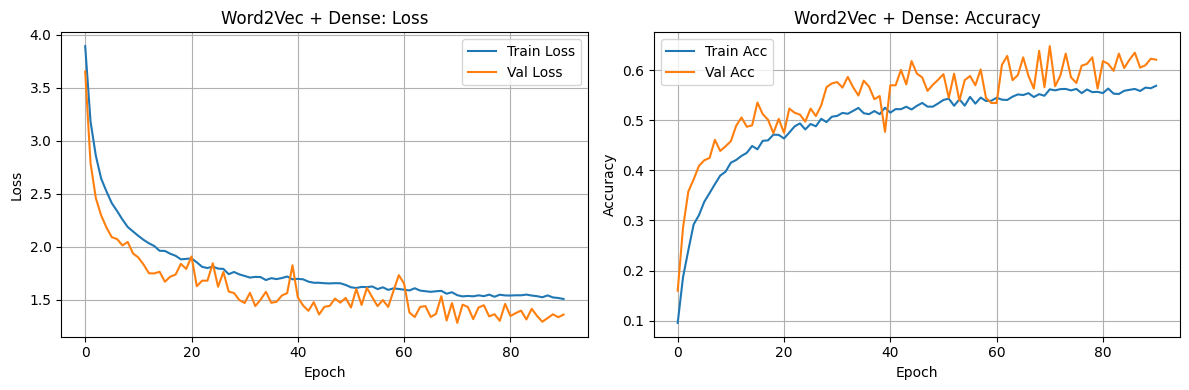

In [59]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_word2vec.history['loss'], label='Train Loss')
plt.plot(history_word2vec.history['val_loss'], label='Val Loss')
plt.title('Word2Vec + Dense: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_word2vec.history['accuracy'], label='Train Acc')
plt.plot(history_word2vec.history['val_accuracy'], label='Val Acc')
plt.title('Word2Vec + Dense: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Nhiệm vụ 3: Mô hình Nâng cao (Embedding Pre-trained + LSTM)

In [60]:
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train_text)

train_sequences = tokenizer.texts_to_sequences(X_train_text)
val_sequences = tokenizer.texts_to_sequences(X_val_text)
test_sequences = tokenizer.texts_to_sequences(X_test_text)

max_len = 50
X_train_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(val_sequences, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post')

print(f"\nVocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Max sequence length: {max_len}")
print(f"Data train padding shape: {X_train_pad.shape}")
print(f"Data validation padding shape: {X_val_pad.shape}")
print(f"Data test padding shape: {X_test_pad.shape}")

word_index = tokenizer.word_index
vocab_size_actual = min(len(word_index) + 1, vocab_size)
embedding_dim = w2v_model.vector_size

embedding_matrix = np.zeros((vocab_size_actual, embedding_dim))

found_words = 0
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        found_words += 1

print(f"Found {found_words}/{vocab_size_actual} words in Word2Vec model")


Vocabulary size: 4265
Max sequence length: 50
Data train padding shape: (8954, 50)
Data validation padding shape: (1076, 50)
Data test padding shape: (1076, 50)
Found 4197/4265 words in Word2Vec model


In [61]:
lstm_pretrained_model = Sequential([
    Embedding(
        input_dim=vocab_size_actual,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),
    LSTM(128, dropout=0.5, recurrent_dropout=0),
    Dense(num_classes, activation='softmax')
])

lstm_pretrained_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_pretrained_model.build(input_shape=(None, max_len))

In [62]:
lstm_pretrained_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 100)        │       426,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,004 (2.11 MB)

 Trainable params: 125,504 (490.25 KB)

 Non-trainable params: 426,500 (1.63 MB)

In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_lstm_pretrained = lstm_pretrained_model.fit(
    X_train_pad, y_train_processed,
    validation_data=(X_val_pad, y_val_processed),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop]
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.0162 - loss: 4.1427 - val_accuracy: 0.0232 - val_loss: 4.0041
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0293 - loss: 3.9785 - val_accuracy: 0.0539 - val_loss: 3.8434
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0554 - loss: 3.8251 - val_accuracy: 0.0725 - val_loss: 3.6388
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0679 - loss: 3.6581 - val_accuracy: 0.0781 - val_loss: 3.5580
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0783 - loss: 3.5731 - val_accuracy: 0.0920 - val_loss: 3.4728
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0788 - loss: 3.5166 - val_accuracy: 0.0883 - val_loss: 3.4302
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0767 - loss: 3.5848 - val_accuracy: 0.0855 - val_loss: 3.4006
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0820 - loss: 3.4790 - val_accuracy: 0.

In [64]:
test_loss_lstm_pre, test_acc_lstm_pre = lstm_pretrained_model.evaluate(X_test_pad, y_test_processed, verbose=1)

y_pred_lstm_pre = np.argmax(lstm_pretrained_model.predict(X_test_pad), axis=1)

f1_macro_lstm_pre = f1_score(y_test, y_pred_lstm_pre, average='macro')

print(f"\nTest Loss: {test_loss_lstm_pre:.3f}")
print(f"Test Accuracy: {test_acc_lstm_pre:.3f}")
print(f"F1-score (Macro): {f1_macro_lstm_pre:.3f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0760 - loss: 3.4237
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Loss: 3.365
Test Accuracy: 0.089
F1-score (Macro): 0.034


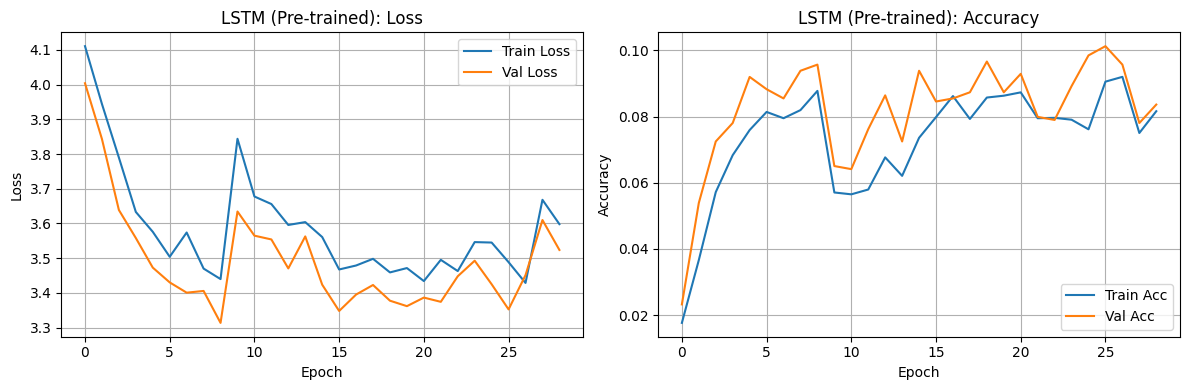

In [65]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm_pretrained.history['loss'], label='Train Loss')
plt.plot(history_lstm_pretrained.history['val_loss'], label='Val Loss')
plt.title('LSTM (Pre-trained): Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm_pretrained.history['accuracy'], label='Train Acc')
plt.plot(history_lstm_pretrained.history['val_accuracy'], label='Val Acc')
plt.title('LSTM (Pre-trained): Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Nhiệm vụ 4: Mô hình Nâng cao (Embedding học từ đầu + LSTM)

In [66]:
lstm_model = Sequential([
    Embedding(
        input_dim=vocab_size_actual,
        output_dim=100,
        input_length=max_len
    ),

    LSTM(128, dropout=0.5, recurrent_dropout=0),

    # Output layer
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.build(input_shape=(None, max_len))

In [67]:
lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 100)        │       426,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,004 (2.11 MB)

 Trainable params: 552,004 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
history_lstm = lstm_model.fit(
    X_train_pad, y_train_processed,
    validation_data=(X_val_pad, y_val_processed),
    epochs=100,
    batch_size=256,
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0164 - loss: 4.1525 - val_accuracy: 0.0177 - val_loss: 4.1326
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0166 - loss: 4.1377 - val_accuracy: 0.0177 - val_loss: 4.1252
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0162 - loss: 4.1287 - val_accuracy: 0.0177 - val_loss: 4.1271
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0149 - loss: 4.1342 - val_accuracy: 0.0177 - val_loss: 4.1245
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0169 - loss: 4.1277 - val_accuracy: 0.0177 - val_loss: 4.1248
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0181 - loss: 4.1288 - val_accuracy: 0.0177 - val_loss: 4.1239
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0126 - loss: 4.1269 - val_accuracy: 0.0177 - val_loss: 4.1255
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0144 - loss: 4.1312 - val_accuracy: 0.

In [69]:
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(X_test_pad, y_test_processed, verbose=1)

y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)

f1_macro_lstm = f1_score(y_test, y_pred_lstm, average='macro')

print(f"\nTest Loss: {test_loss_lstm:.3f}")
print(f"Test Accuracy: {test_acc_lstm:.3f}")
print(f"F1-score (Macro): {f1_macro_lstm:.3f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0061 - loss: 4.1532
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Loss: 4.124
Test Accuracy: 0.018
F1-score (Macro): 0.001


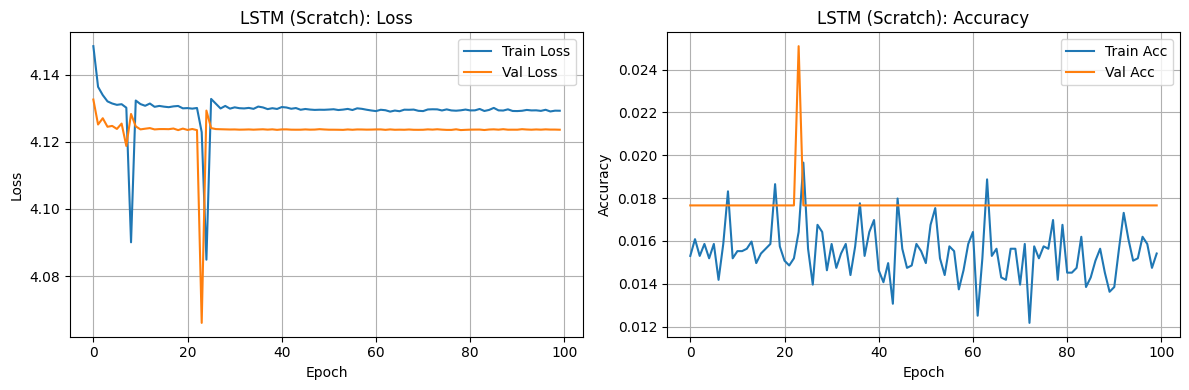

In [70]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM (Scratch): Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.title('LSTM (Scratch): Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Nhiệm vụ 5: Đánh giá, So sánh và Phân tích

## 1. So sánh định lượng

In [74]:
results = pd.DataFrame({
    'Pipeline': [
        'TF-IDF + Logistic Regression',
        'Word2Vec (Avg) + Dense',
        'Embedding (Pre-trained) + LSTM',
        'Embedding (Scratch) + LSTM'
    ],
    'Accuracy': [
        accuracy_tfidf_log_reg,
        test_acc_word2vec,
        test_acc_lstm_pre,
        test_acc_lstm
    ],
    'F1-score (Macro)': [
        f1_macro_tfidf_log_reg,
        f1_macro_word2vec,
        f1_macro_lstm_pre,
        f1_macro_lstm
    ],
    'Test Loss': [
        'N/A',
        f"{test_loss_word2vec:.3f}",
        f"{test_loss_lstm_pre:.3f}",
        f"{test_loss_lstm:.3f}"
    ]
})

print("="*80)
print("BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH")
print("="*80)
print(results.to_string())
print("="*80)

BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH
                         Pipeline  Accuracy  F1-score (Macro) Test Loss
0    TF-IDF + Logistic Regression  0.833643          0.830032       N/A
1          Word2Vec (Avg) + Dense  0.602230          0.578762     1.320
2  Embedding (Pre-trained) + LSTM  0.089219          0.034037     3.365
3      Embedding (Scratch) + LSTM  0.017658          0.000542     4.124


## 2. Phân tích định tính

**a. Lấy dự đoán từ cả 4 mô hình. b. So sánh với nhãn thật**

In [82]:
test_difficult_sentences = [
    "can you remind me to not call my mom",
    "is it going to be sunny or rainy tomorrow",
    "find a flight from new york to london but not through paris"
]

labels = ["reminder_create", "weather_query", "flight_search"]

print("="*80)
print("PHÂN TÍCH ĐỊNH TÍNH")
print("="*80)

for idx, (sentence, label_) in enumerate(zip(test_difficult_sentences, labels), 1):
    print(f"\n{idx}. Test difficult sentence: '{sentence}'")
    print("-" * 80)

    # TF-IDF + LR
    pred_tfidf = tfidf_log_reg_pipeline.predict([sentence])[0]
    print(f"TF-IDF + LR:{label_encoder.classes_[pred_tfidf]}")

    # Word2Vec + Dense
    sentence_vec = sentence_to_avg_vector(sentence, w2v_model).reshape(1, -1)
    pred_w2v = word2vec_dense_model.predict(sentence_vec, verbose=0)
    pred_w2v_class = label_encoder.classes_[np.argmax(pred_w2v)]
    print(f"Word2Vec + Dense: {pred_w2v_class}")

    # LSTM Pre-trained
    sentence_seq = tokenizer.texts_to_sequences([sentence])
    sentence_pad = pad_sequences(sentence_seq, maxlen=max_len, padding='post')
    pred_lstm_pre = lstm_pretrained_model.predict(sentence_pad, verbose=0)
    pred_lstm_pre_class = label_encoder.classes_[np.argmax(pred_lstm_pre)]
    print(f"LSTM (Pre-trained): {pred_lstm_pre_class}")

    # LSTM Scratch
    pred_lstm = lstm_model.predict(sentence_pad, verbose=0)
    pred_lstm_class = label_encoder.classes_[np.argmax(pred_lstm)]
    print(f"LSTM (Scratch): {pred_lstm_class}")

    print(f"Label: {label_}")

PHÂN TÍCH ĐỊNH TÍNH

1. Test difficult sentence: 'can you remind me to not call my mom'
--------------------------------------------------------------------------------
TF-IDF + LR:calendar_set
Word2Vec + Dense: email_query
LSTM (Pre-trained): play_music
LSTM (Scratch): qa_definition
Label: reminder_create

2. Test difficult sentence: 'is it going to be sunny or rainy tomorrow'
--------------------------------------------------------------------------------
TF-IDF + LR:weather_query
Word2Vec + Dense: weather_query
LSTM (Pre-trained): play_podcasts
LSTM (Scratch): qa_definition
Label: weather_query

3. Test difficult sentence: 'find a flight from new york to london but not through paris'
--------------------------------------------------------------------------------
TF-IDF + LR:transport_query
Word2Vec + Dense: transport_query
LSTM (Pre-trained): transport_ticket
LSTM (Scratch): qa_definition
Label: flight_search


**c. Nhận xét xem mô hình nào (đặc biệt là các mô hình LSTM) đưa ra dự đoán chính xác hơn và tại sao. Liệu khả năng xử lý chuỗi có giúp chúng hiểu đúng ý định trong các câu phức tạp này không**

*Mô hình Phi-Chuỗi (TF-IDF + LR, Word2Vec + Dense):*
* Ở Câu 2, chúng hoạt động tốt hơn 2 mô hình LSTM. Điều này cho thấy với câu hỏi thời tiết đơn giản, sự hiện diện của các từ khóa như "sunny", "rainy", "tomorrow" là đủ để phân loại chính xác, và mô hình TF-IDF dựa trên tần suất từ khóa đã làm việc hiệu quả.

* Ở Câu 1 và Câu 3, chúng không hoàn toàn chính xác nhưng ở Câu 3 đưa ra nhãn gần đúng (transport_query).

*Mô hình Xử lý Chuỗi (LSTM):*
* LSTM (Pre-trained) và LSTM (Scratch) có hiệu suất kém nhất trong cả ba trường hợp, thường xuyên đưa ra các nhãn sai lệch hoàn toàn (play_music, play_podcasts, qa_definition).

* Đặc biệt, LSTM (Scratch) dường như mặc định dự đoán qa_definition cho hầu hết các câu khó, có thể là do bộ dữ liệu training nhỏ hoặc lỗi trong quá trình huấn luyện khiến mô hình chưa học được mối quan hệ chuỗi từ ngữ hiệu quả.

Khả năng xử lý chuỗi của các mô hình LSTM hiện tại đã không giúp chúng hiểu đúng ý định trong ba câu phức tạp. Các mô hình LSTM (đặc biệt là bản huẩn luyện từ đầu) trong thử nghiệm này không được huấn luyện đủ tốt hoặc dữ liệu huấn luyện chưa đủ để xử lý các câu có cấu trúc phức tạp.